# Dirichlet distribution and Dirichlet process

In this notebook we discuss the Dirichlet distribution and the Dirichlet process (DP). We show what kind of samples these distributions they generate, and how such samples can be drawn.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Dirichlet distribution

The Dirichlet distribution is a distribution over discrete finite probability measures.

We show two methods for generating a sample from a Dirichlet distribution. These correspond to three views on the Dirichlet distribution. Each of these views can be extended in an infinite manner to the Dirichlet process.

## The Polya Urn Scheme

The scheme is as follows. We start with an urn containing $\alpha_i$ marbles of color $i = 1,2,\dots,k$. At each step a marble is picked uniformly at random from the urn, and then placed back in the urn with an additional marble of the same color. This is repeated for some number $n$ times.

To sample from a Dirichlet$(\alpha_1, \alpha_2, \alpha_3)$ we start with the urn $[\alpha_1, \alpha_2, \alpha_3]$, and repeat the above process $n$ times. In the limit, as $n\to \infty$, the proportions $(\beta_1, \beta_2, \beta_3)$ of marbles in the final urn converge are a sample of the Dirichlet$(\alpha_1, \alpha_2, \alpha_3)$ distribution.

For computational purposes, we truncate $n$ at some large value.

In [3]:
from collections import defaultdict

def polya_urn(urn, n):
    '''
    :param urn: e.g. [2,2,1] for three colors with resp. amounts of marbles
    :param n: number of repetitions
    '''
    new_urn = [v for i, v in enumerate(urn)]
    path = {i: [marble/float(sum(urn))] for i, marble in enumerate(urn)}
    for i in range(n):
        draw = np.argmax(np.random.multinomial(1, [v[-1] for k, v in path.iteritems()]))
        new_urn[draw] += 1
        for i, marble in enumerate(new_urn):
            path[i].append(marble/float(sum(new_urn)))
    return path

def plot_polya(path):
    '''
    :param path: a sample path as returned by polya_urn
    '''
    for color, marbles in path.iteritems():
        plt.plot(range(len(marbles)), marbles)
    plt.show()
    plt.clf()

def polya_urn_multiple(urn, n, k):
    # holds all sample paths per colors 
    paths = defaultdict(list)
    # holds all final sample values per color
    finals_dict = defaultdict(list)
    for i in range(k):
        # print urn
        path = polya_urn(urn, n)
        for color, sample_path in path.iteritems():
            paths[color].append(sample_path)
            # save the last value of each path
            finals_dict[color].append(sample_path[-1])
    return paths, finals_dict

def plot_polya_multiple(paths):
    # :param path: a sample path as returned by polya_urns
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    for i, sample_paths in paths.iteritems():
        for path in sample_paths:
            # plot each path
            plt.plot(range(len(path)), path, alpha=0.2, color=colors[i])
        # plot average:
        plt.plot(range(len(path)), reduce(np.add, sample_paths)/float(len(sample_paths)), color=colors[i])
    plt.show()
    plt.clf()
    
def polya_hist(finals_dict):
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    plt.axis([0, 1, 0, 15])
    for i, final in finals_dict.iteritems():
        n, bins, patches = plt.hist(final, 30, normed=1, facecolor=colors[i], alpha=0.75)
    plt.show()
    plt.clf()

We can plot a single sample path of length, say, 1000.

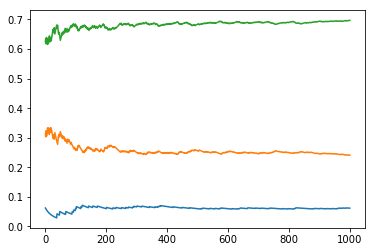

In [97]:
start_urn = [2,10,20]

path = polya_urn(start_urn, 1000)
plot_polya(path)

Or plot 50 sample paths, together with the averages of each marble color:

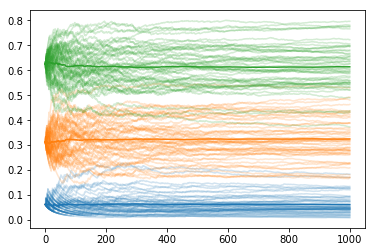

In [98]:
paths, finals_dict = polya_urn_multiple(start_urn, 1000, 50)

plot_polya_multiple(paths)

The fraction of marbles in the final urn are our simulated Dirichlet sample. We can plot the hisogram of a large sample of these:

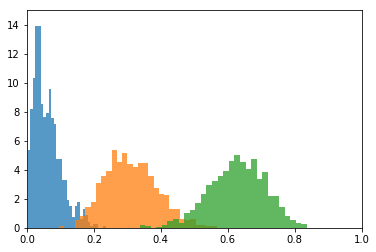

In [99]:
paths, finals_dict = polya_urn_multiple(start_urn, 1000, 1000)

polya_hist(finals_dict)

This histogram is identical to a histogram of Dirichlet samples generated using numpy:

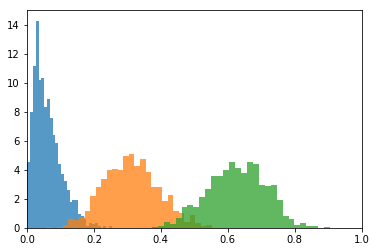

In [100]:
d = defaultdict(list)
D = np.random.dirichlet(start_urn, size = 1000)

plt.axis([0, 1, 0, 15])
for i in range(3):
    n, bins, patches = plt.hist(D[:,i], 30, normed=True, facecolor=colors[i], alpha=0.75)
plt.show()

# Dirichlet process

The Dirichlet process (DP) is a stochastic process whose sample paths are random probability measures. Both methods described above have natural extensions that make them infinite-dimensional.

## Blackwell-MacQueen Urn Scheme

The infinite-dimensional generalization of the Polya Urn Scheme. Apart from uniformly sampling marbles from the urn and incrementing the count of the drawn marble, the BMQ urn scheme alows for aditional new marbles to be added.

We start with an empty urn. At step 1 some color $\theta_1 \sim H$ is drawn and a marble of this color is put in the urn. At step $n+1$ we: (1) with probability $\frac{\alpha}{n+\alpha}$ pick a new color $\theta_{n+1} \sim H$ and add marble $n+1$ with that color to the urn; or (2) with probability $\frac{n}{n+\alpha}$ uniformly pick a marble from the urn, let marble $n+1$ have that color - i.e. set $\theta_{n+1}=\theta_j$ where $\theta_j$ is the color of the drawn marble - and return both marbles to the urn. This last step is the same as in the Polya urn scheme. Hence:

$$
\theta_{n+1}|\theta_{1},\dots,\theta_{n} \sim \frac{\alpha}{\alpha+n}H + \frac{n}{\alpha+n}\frac{1}{n}\displaystyle\sum_{i=1}^{n}\delta_{\theta_i}
$$


where in $\frac{1}{n}\sum_{i=1}^{n}\delta_{\theta_i}$ we recognize the empirical distribution of the colors of the marbles in the urn.

In the limit of $n\to\infty$, this will give us a sample $G \sim \text{DP}(\alpha, H)$.

The resulting pdf for $G$ is then $\displaystyle\sum_{i=1}^{\infty}\pi_i\delta(\theta_i)$ where $\pi_i$ is the fraction of marbles with color $\theta_i$.

The choice of distribution $H$ is open. Below we choose $H= N(0,1)$. Note: this means our 'colors' are now real-valued numbers.

In [38]:
import random

def BMQ_urn(n, alpha):
    """
    :param n: the size of out sample (the larger, the better the sample)
    :param alpha: the conentration paramater (should be >= 0)
    """
    # we choose H the normal distribution

    alpha = float(alpha)
    urn = []
    urn_count = defaultdict(int)
    
    # add the first marble
    marble = np.random.normal()
    urn_count[marble] += 1
    urn.append(marble)
    
    for i in range(2,n):
        if np.random.binomial(1,(alpha/(alpha+i-1))):
            marble = np.random.normal()
            urn_count[marble] += 1
            urn.append(marble)
        else:
            marble = random.choice(urn)
            urn_count[marble] += 1
            urn.append(marble)
    return urn, urn_count

We can plot the resulting distribution as follows: for each color $\theta_i$ plot a vertical line at $\theta_i$ with height $f_{\theta_i}$, where $f_{\theta_i}$ is the fraction of marbles with color $\theta_i$.

67


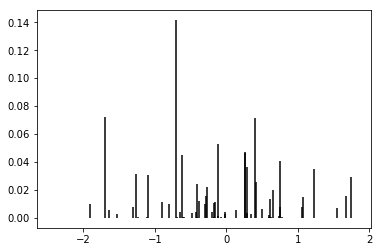

In [35]:
size = 10000
urn, urn_count = BMQ_urn(size, alpha=10)

print len(set(urn))

keys = urn_count.keys()
values = [urn_count[k]/float(size) for k in keys]
plt.vlines(keys, np.zeros(len(keys)), values, alpha=1)

## Stick breaking

We show how to draw a the infinite vector $\beta = (\beta_1,\beta_2,\dots)\sim \text{GEM}(\alpha)$:

For $i=1,2,\dots$:

$\\\qquad\pi_i \sim \text{Beta}(1,\alpha)$

$\beta_k = \pi_k \displaystyle\prod_{i=1}^{k-1}(1-\pi_i)$


Of course, computers are finite objects - hence we truncate the proces at some large value $n$, and sample $u_i$ only for $i = 1,\dots,n$.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def stick_breaking(alpha, size):
    """
    :param alpha: >= 0
    :param size: truncate the stick-breaking process at this point
    """
    betas = np.random.beta(1, alpha, size=size)
    return [betas[i]*np.prod([1-betas[j] for j in range(i)]) for i in range(size)]

We can plot the sticks as lines in order of occurence. We can then clearly see the effects of $\alpha$: smaller values of $\alpha$ cause larger pieces of the stick to break of; larger values cause smaller pieces to break of.

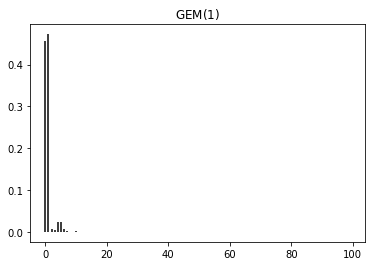

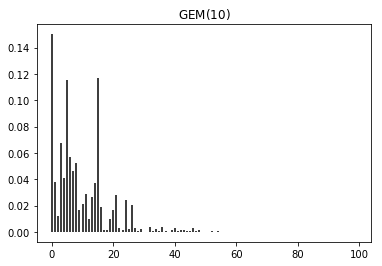

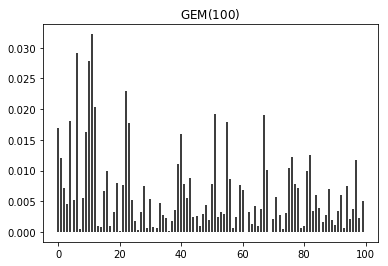

In [38]:
size = 100

sticks = stick_breaking(1, size)
plt.vlines(range(size), [0]*size, sticks)
plt.title('GEM$(1)$')
plt.show()

sticks = stick_breaking(10, size)
plt.vlines(range(size), [0]*size, sticks)
plt.title('GEM$(10)$')
plt.show()

sticks = stick_breaking(100, size)
plt.vlines(range(size), [0]*size, sticks)
plt.title('GEM$(100)$')
plt.show()

This is of course the result of the respective Beta distributions used. Below we plot the Beta$(1,$alpha$)$ distribution for various values of $\alpha$.

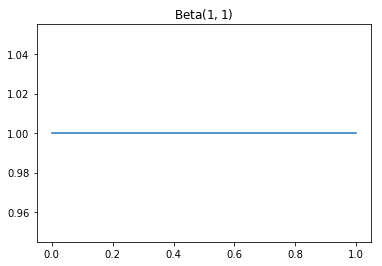

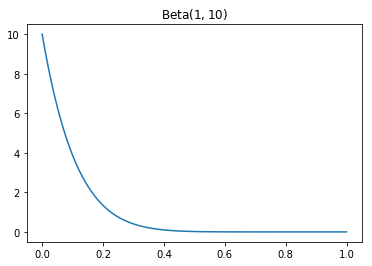

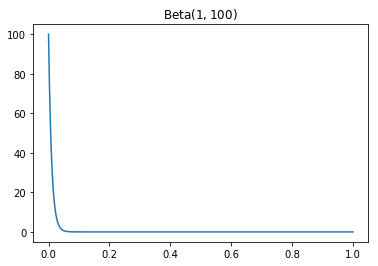

In [37]:
from scipy.stats import beta

xs = np.linspace(0,1,1000)
plt.plot(xs, map(lambda x: beta.pdf(x, 1, 1), xs))
plt.title('Beta$(1,1)$')
plt.show()

plt.plot(xs, map(lambda x: beta.pdf(x, 1, 10), xs))
plt.title('Beta$(1,10)$')
plt.show()

plt.plot(xs, map(lambda x: beta.pdf(x, 1, 100), xs))
plt.title('Beta$(1,100)$')
plt.show()

If we choose a base distribution $H$ we can again plot the resulting pdf of $G\sim \text{DP}(\alpha, H)$, by locating the sticks generated by GEM at locations drawn from $H$.

alpha = 1


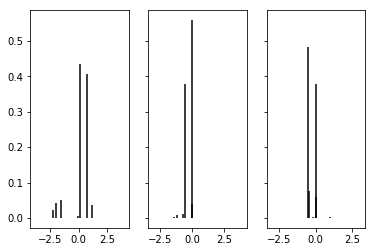

alpha = 10


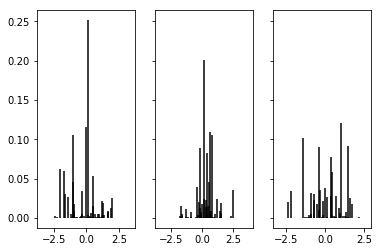

alpha = 100


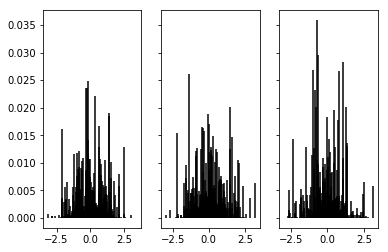

alpha = 1000


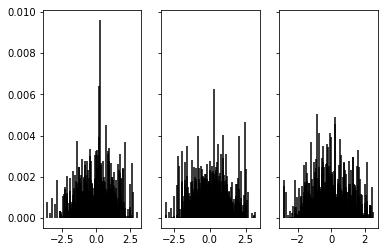

In [37]:
size = 1000

def plot_stick_breaking(alpha_values=[1, 10, 100, 1000], size=1000):
    '''
    :param size: truncate the stick-breaking process at this point
    '''
    for alpha in alpha_values:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
        ax = (ax1, ax2, ax3)
        for j in range(3):
            # Our computers are finite... so we truncate the stick-
            # breaking process at size. This only becomes a problem 
            # for very large values of alpha.
            p = stick_breaking(alpha, size)
            # draw 'colors' for each of the stick weights
            xs = np.random.normal(size=size)
            ax_j = ax[j]
            ax_j.vlines(xs, np.zeros(size), p, alpha=1)
        print "alpha = {}".format(alpha)
        plt.show()
        plt.clf()
        
plot_stick_breaking(size=10**3)

## Chinese restaurant process

The dynamics for a generalized version of the CRP called the Pitman-Yor process are as follows. (The CRP is the special case of the PY-process when $d=0$.)
 
$p(z_i = j \mid z_1,\dots,z_{i-1},\alpha) =
\begin{cases} 
      \frac{\alpha + d\dot b}{\alpha + (i-1)} & \text{if }j \text{ is the first unoccupied table} \\
      \frac{n_j - d}{\alpha + (i-1)} & \text{otherwise}
   \end{cases}$

where $n_j$ are the number of guests at table $j$, $b$ is the number of occupied tables, and $\alpha$ and $d$ are parameters such that $\alpha \geq 0$ and $0\leq d < 1$.

In [212]:
def pitman_yor(n, alpha=1, d=1):
    number_of_tables = []
    tables = []
    proportion = []
    assignments = []
    for i in range(0,n):
        b = len(tables)
        number_of_tables.append(b)
        probs = [(tables[j] - d)/float((alpha + i)) for j in range(b)] + [(alpha + d*b)/float((alpha + i))]
        draw = np.random.multinomial(1, probs)
        z = np.argmax(draw)
        if z > b-1:
            # z is not one of the already taken tables
            tables = tables + [1]
        else:
            # seat z at that table
            tables[z] += 1
        p = sum(map(lambda x: int(x==1), tables))/float(len(tables))
        proportion.append(p)
        assignments.append(z)
    return number_of_tables, proportion, assignments

def plot_pitman_scatter(ds, a):
    """
    Draws len(ds) scatter plots (one for each d in ds)
    where a dot at (x,y) means that guest x was assigned 
    to table y. 
    """
    for d in ds:
        results, proportion, assignments = pitman_yor(n, alpha=a, d=d)
        plt.scatter(range(n), assignments, s=1)
        plt.show()
        plt.clf()

def plot_pitman_number(ds, a):
    for d in ds:
        results, proportion, assignments = pitman_yor(n, alpha=a, d=d)
        plt.loglog(range(n), results)
        plt.show()
        plt.clf()

def plot_pitman_proportion(ds, a):
    for d in ds:
        results, proportion, assignments = pitman_yor(n, alpha=a, d=d)
        plt.plot(range(n), proportion)
        plt.show()
        plt.clf()

alpha=0.1, ds=[0.9, 0.5, 0.1]


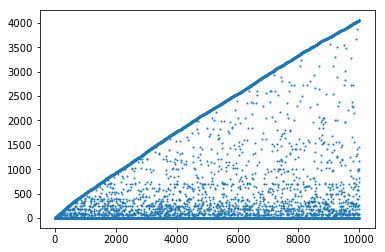

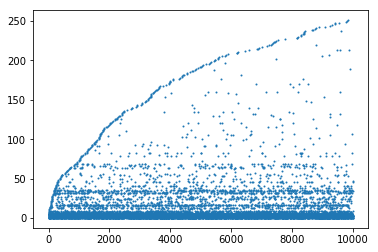

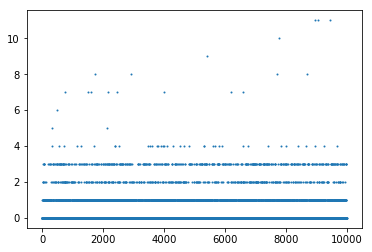

alpha=0.5, ds=[0.9, 0.5, 0.1]


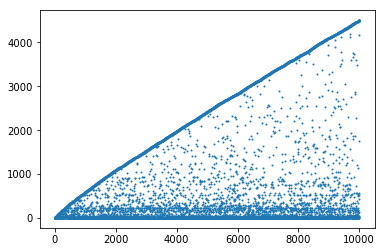

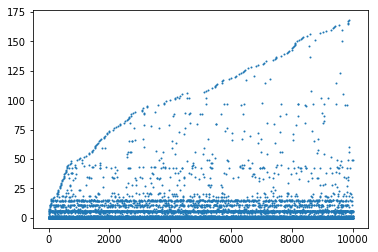

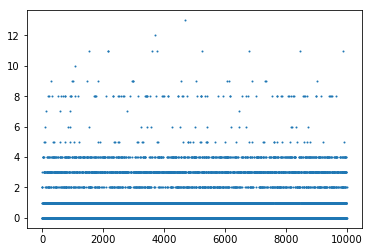

alpha=1, ds=[0.9, 0.5, 0.1]


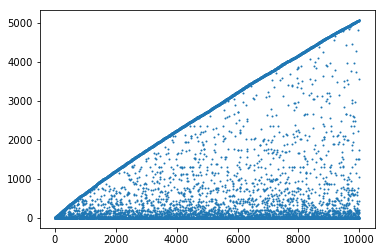

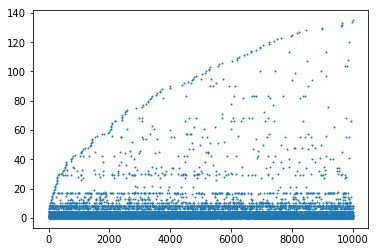

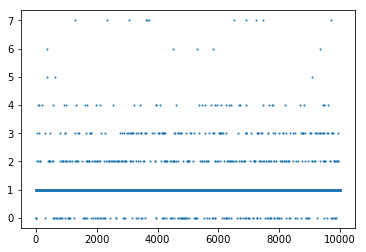

alpha=10, ds=[0.9, 0.5, 0.1]


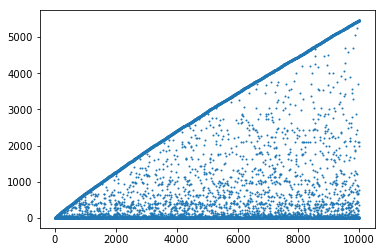

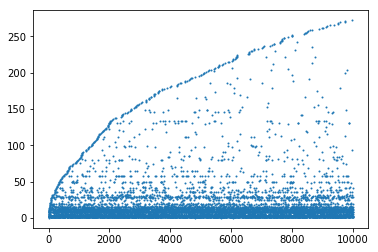

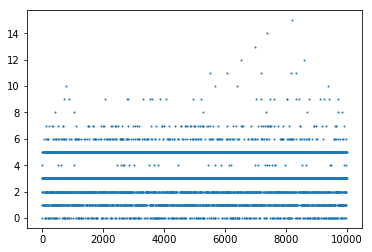

In [228]:
n = 10**4
ds = [0.9, 0.5, 0.1]
# plot_pitman_scatter([0], 10000)

for a in [0.1, 0.5, 1, 10]:
    print "alpha={0}, ds={1}".format(a, ds)
    plot_pitman_scatter(ds, a)

### Tables and words

We can note how the allocation of tables is similar to the occurence of new words in a text. We illustrate this with three books from the NLTK Gutenberg corpus.

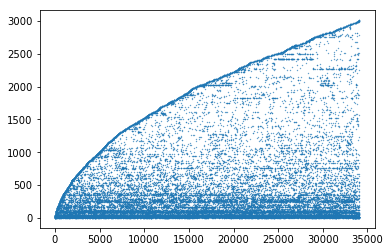

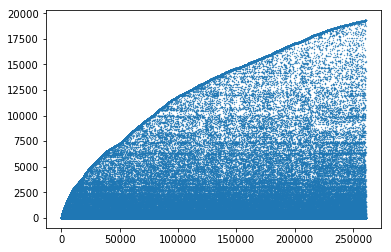

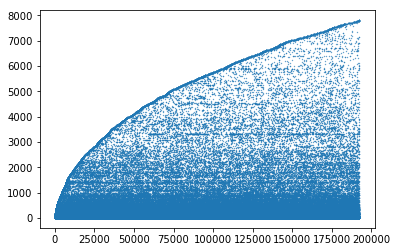

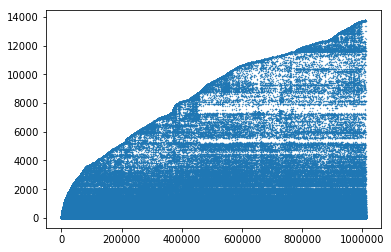

In [184]:
import nltk

emma = nltk.corpus.gutenberg.words('austen-emma.txt')[10:]
bible = nltk.corpus.gutenberg.words('bible-kjv.txt')[25:]
moby = nltk.corpus.gutenberg.words('melville-moby_dick.txt')[25:]
alice = nltk.corpus.gutenberg.words('carroll-alice.txt')[25:]


def new_words(text):
    d = defaultdict(int)
    i = 0
    assignments = []
    for word in text:
        if d[word] == 0:
            d[word] = i
            i += 1
        assignments.append(d[word])
    return assignments

def plot_assignments(assignments):
    plt.scatter(range(len(assignments)), assignments, s=0.1, alpha=1)
    plt.show()
    plt.clf()

alice_assignments = new_words(alice)
moby_assignments = new_words(moby)
emma_assignments = new_words(emma)
bible_assignments = new_words(bible)

plot_assignments(alice_assignments)
plot_assignments(moby_assignments)
plot_assignments(emma_assignments)
plot_assignments(bible_assignments)